# Tarea 3

### Importante 1: ###
Este notebook está diseñado para ejecutar en Julia 1.6-.

### Importante 2: ###
Renombre el archivo como: 
**nombredelgrupo_tarea_2.ipynb**

**Todo el código generado y la presentación deberá estar incluida en este notebook.**

**El objetivo de la tarea es variado:**

1. Entender la propagación de ondas y relacionarla con la necesidad de imponer condiciones de contorno de acuerdo al sentido de la propagación.

2. Comprender el esquema de imponer condiciones de contorno usando operadores de diferencia finita con la propiedad de suma por partes. 




**1)** En el directorio encontrará un notebook en Julia que permite evolucionar la ecuación de advección dando una condición de contorno en el extremo desde donde ingresa la solución en la región de integración.
Pruebe con distintas condiciones iniciales y de contorno. ¿Qué pasa si cambia el signo de la velocidad?


In [2]:
using DifferentialEquations
using Plots
using LinearAlgebra
using BandedMatrices
using SparseArrays

In [58]:
function create_D_2_sbp(N)
    D_2_sbp = Tridiagonal([-0.5 for i in 1:N-1],[0.0 for i in 1:N],[0.5 for i in 1:N-1])
    D_2_sbp[1,1] = -1.0
    D_2_sbp[1,2] = 1.0
    D_2_sbp[end,end] = 1.0
    D_2_sbp[end,end-1] = -1.0
    h2 = Diagonal([1. for i in 1:N])
    h2[1,1] = 0.5
    h2[N,N] = 0.5
    return h2, D_2_sbp
end

create_D_2_sbp (generic function with 1 method)

In [59]:
h2, D_2_sbp = create_D_2_sbp(8);
#Matriz del producto interno H
display(h2)
#Operador de derivada de segundo orden en el interior, primer orden en el borde
display(D_2_sbp)

8×8 Diagonal{Float64, Vector{Float64}}:
 0.5   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   0.5

8×8 Tridiagonal{Float64, Vector{Float64}}:
 -1.0   1.0    ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
 -0.5   0.0   0.5    ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅   -0.5   0.0   0.5    ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅   -0.5   0.0   0.5    ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅   -0.5   0.0   0.5    ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅   -0.5   0.0   0.5   ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -0.5   0.0  0.5
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0  1.0

In [60]:
function F_sbp_matricial!(du,u,p,t)
    # second order version
    h11, D, c,g, parg,dx = p
    h = 1. /dx
    mul!(du, D, u, -c*h,0)
    du[1] += c * (h/h11)*(g(t, parg) - u[1])
end

F_sbp_matricial! (generic function with 1 method)

In [61]:
function F2_sbp!(du,u,p,t)
    # second order version
    c, g, parg, dx = p
    #c -> velocidad de propagación (debe ser > 0)
    #g -> condición de borde
    #parg -> parámetros de g
    h = 1. /dx 
    h11 = 0.5 # -> componente 11 de la matriz del producto interno.
    #Extremo izquierdo
    du[1] = (-c*h*(u[2]-u[1]) +             #Derivada a primer orden que nos permite satisfacer SBP
    c*h/h11*(g(t, parg) - u[1]))    #SAT_1 
    #resolvemos los puntos interiores
    #du[i] = c*(u[i+1]-u[i-1])/dx
    @. du[2:end-1] = -c*0.5*h*(u[3:end]-u[1:end-2])
    #Extremos derecho
    du[end] = -c*h*(u[end]-u[end-1])        #Derivada a primer orden que nos permite satisfacer SBP

end

F2_sbp! (generic function with 1 method)

**Dato Inicial**

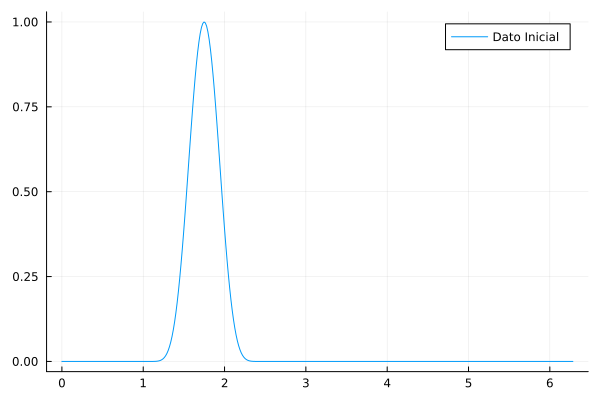

In [62]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                        #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
u0 = zeros(N)                          #Vector del dato inicial
x0=1.0
x1 = 2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end

plot(x,u0, label = "Dato Inicial")

In [63]:
c = 1.0              #Velocidad de advección
function g(t, ω)     #Condición de borde en x=0. Puede cambiarla por lo que quiera!
    return sign(sin(t*ω))        #escalon
    #t < pi ? sin(t) : 0.0        #pulso
    # return sin(t*ω)*cos(2*ω*t)    #onda modulada
end
T = 20.0 #tiempo final de evolución
ω = 1.0
p = (c, g, ω, dx)
h2, D_2_sbp = create_D_2_sbp(N);
pmatricial = (h2[1,1], D_2_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

0.01574733159694132

In [64]:
probmatricial = ODEProblem(F_sbp_matricial!,u0,(0.0,T),pmatricial);
prob = ODEProblem(F2_sbp!,u0,(0.0,T),p);

In [65]:
@time solmatricial = solve(probmatricial,RK4(),dt=dt, adaptive = false);
@time sol = solve(prob,RK4(),dt=dt, adaptive = false);

  0.271283 seconds (177.31 k allocations: 20.935 MiB, 91.71% compilation time: 100% of which was recompilation)
  0.761451 seconds (1.06 M allocations: 94.412 MiB, 8.17% gc time, 88.90% compilation time: 100% of which was recompilation)


┌ Info: Saved animation to 
│   fn = H:\2022\PDE_FAMAF\GIT_Famaf_PDE\Problems\Numéricos\Tarea 3\wave_anim_matricialY.gif
└ @ Plots C:\Users\invmecanica-m8\.julia\packages\Plots\lW9ll\src\animation.jl:137


Plots.AnimatedGif("H:\\2022\\PDE_FAMAF\\GIT_Famaf_PDE\\Problems\\Numéricos\\Tarea 3\\wave_anim_matricialY.gif")
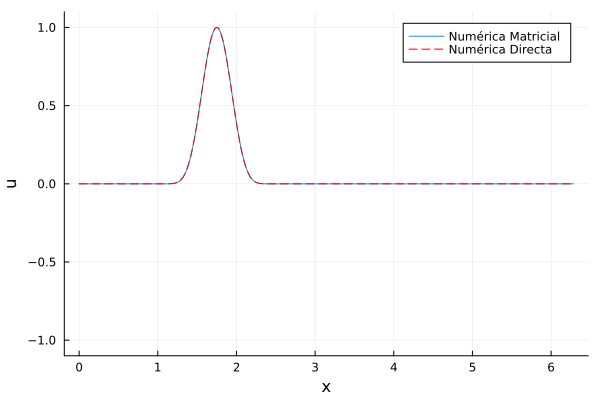

In [21]:
anim = @animate for t in solmatricial.t[1:4:end]
    plot(x, solmatricial(t), yaxis = ("u", (-1.3,1.3)), xlabel = "x", label = "Numérica Matricial")
    plot!(x, sol(t), yaxis = ("u", (-1.1,1.1)),linestyle=:dash,color=:red, xlabel = "x", label = "Numérica Directa")
    # plot(x, g(t, ω), ylim = (-1.1, 1.1),
    #     xlabel = "\$x\$", label = "solución exacta", legendfontsize = 10,
    # ylabel = "\$u\$")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "wave_anim_matricialY.gif", fps = 30)

-----------------

**2)** Vea que la convergencia del método, en norma $L^2$, es de segundo orden, pese a que la aproximación en el borde es de primer orden.

-----------------

-----------------

**3)** El operador differencia finita con suma por partes de 4to orden tiene las siguientes entradas matriciales cerca de $[1,1]$ y $[N,N]$:

-------------

In [ ]:
using LinearAlgebra

In [25]:
Head=[-1.4117647059 1.7352941176 -0.23529411765 -0.088235294118 0.0 0.0
    -0.5 0.0 0.5 0.0 0.0 0.0
 0.093023255814 -0.68604651163 0.0 0.68604651163 -0.093023255814 0.0
 0.030612244898 0.0 -0.60204081633 0.0 0.65306122449 -0.081632653061]
display(Head)

4×6 Matrix{Float64}:
 -1.41176     1.73529   -0.235294  -0.0882353   0.0         0.0
 -0.5         0.0        0.5        0.0         0.0         0.0
  0.0930233  -0.686047   0.0        0.686047   -0.0930233   0.0
  0.0306122   0.0       -0.602041   0.0         0.653061   -0.0816327

In [24]:
D8 = [+0       +0.667   -0.083   +0       +0       +0       +0       +0       +0       +0       +0.083   -0.667  
  -0.667   +0       +0.667   -0.083   +0       +0       +0       +0       +0       +0       +0       +0.083  
  +0.083   -0.667   +0       +0.667   -0.083   +0       +0       +0       +0       +0       +0       +0      
  +0       +0.083   -0.667   +0       +0.667   -0.083   +0       +0       +0       +0       +0       +0      
  +0       +0       +0.083   -0.667   +0       +0.667   -0.083   +0       +0       +0       +0       +0      
  +0       +0       +0       +0.083   -0.667   +0       +0.667   -0.083   +0       +0       +0       +0      
  +0       +0       +0       +0       +0.083   -0.667   +0       +0.667   -0.083   +0       +0       +0      
  +0       +0       +0       +0       +0       +0.083   -0.667   +0       +0.667   -0.083   +0       +0      
  +0       +0       +0       +0       +0       +0       +0.083   -0.667   +0       +0.667   -0.083   +0      
  +0       +0       +0       +0       +0       +0       +0       +0.083   -0.667   +0       +0.667   -0.083  
  -0.083   +0       +0       +0       +0       +0       +0       +0       +0.083   -0.667   +0       +0.667  
  +0.667   -0.083   +0       +0       +0       +0       +0       +0       +0       +0.083   -0.667   +0      ]
display(D8)

12×12 Matrix{Float64}:
  0.0     0.667  -0.083   0.0     0.0    …   0.0     0.0     0.083  -0.667
 -0.667   0.0     0.667  -0.083   0.0        0.0     0.0     0.0     0.083
  0.083  -0.667   0.0     0.667  -0.083      0.0     0.0     0.0     0.0
  0.0     0.083  -0.667   0.0     0.667      0.0     0.0     0.0     0.0
  0.0     0.0     0.083  -0.667   0.0        0.0     0.0     0.0     0.0
  0.0     0.0     0.0     0.083  -0.667  …   0.0     0.0     0.0     0.0
  0.0     0.0     0.0     0.0     0.083     -0.083   0.0     0.0     0.0
  0.0     0.0     0.0     0.0     0.0        0.667  -0.083   0.0     0.0
  0.0     0.0     0.0     0.0     0.0        0.0     0.667  -0.083   0.0
  0.0     0.0     0.0     0.0     0.0       -0.667   0.0     0.667  -0.083
 -0.083   0.0     0.0     0.0     0.0    …   0.083  -0.667   0.0     0.667
  0.667  -0.083   0.0     0.0     0.0        0.0     0.083  -0.667   0.0

Más una parte usual en bandas de ancho 5. Note que la parte de abajo de la matriz no es el Head sino una transposición apropiada y un cambio de signo de la misma. Es decir,
`D[n-(i-1),n-(j-1)] = -D[i,j]`.

Por su parte, el producto escalar viene dado por:

In [49]:
function h4!(N) 
    h4 = Diagonal([1. for i in 1:N])
    h4[1,1] = 17/48
    h4[2,2] = 59/48
    h4[3,3] = 43/48
    h4[4,4] = 49/48
    h4[end,end] = h4[1,1]
    h4[end-1,end-1] = h4[2,2]
    h4[end-2,end-2] = h4[3,3]
    h4[end-3,end-3] = h4[4,4]
    return h4
end
h4!(5)


5×5 Diagonal{Float64, Vector{Float64}}:
 0.354167   ⋅        ⋅         ⋅        ⋅ 
  ⋅        1.22917   ⋅         ⋅        ⋅ 
  ⋅         ⋅       0.895833   ⋅        ⋅ 
  ⋅         ⋅        ⋅        1.22917   ⋅ 
  ⋅         ⋅        ⋅         ⋅       0.354167

Contruya el operador de 4to orden y constate que converge, en norma $L^2$, en orden 4 (pese a que cerca del borde la convergencia baja a segundo orden). Constate que satisface suma por partes.

In [84]:

function create_D_4_SBP(N)
    D_4_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D_4_per[band(0)] .= 0.0
    D_4_per[band(1)] .= 2.0/3.0
    D_4_per[band(-1)] .= -2.0/3.0
    D_4_per[band(2)] .= -1.0/12.0
    D_4_per[band(-2)] .= 1.0/12.0
        
    # Head
 #    D_4_per[1:4,1:6] .= [-1.4117647059 1.7352941176 -0.23529411765 -0.088235294118 0.0 0.0
 #    -0.5 0.0 0.5 0.0 0.0 0.0
 # 0.093023255814 -0.68604651163 0.0 0.68604651163 -0.093023255814 0.0
 # 0.030612244898 0.0 -0.60204081633 0.0 0.65306122449 -0.081632653061]
    # for i=1:4,j=1:6;D_4_per[N-(i-1),N-(j-1)]=-Head[i,j];end # 
            #Tail=copy(transpose(Head))
        #Tail[N-(i-1),N-(j-1)].=-Head[i,j for i in 1:4 ,for j in 1:6]

    # ==================================================
   # 2nd Order
#     Head = [-3.0/2.0          2.  -1.0/2.0       0.0   # forward 2nd Order
#                      0.0   -3.0/2.0          2. -1.0/2.0   # forward 2nd Order
#                ]
#     D_4_per[1:2,1:4] .= Head
    
#     for i=1:2,j=1:4;D_4_per[N-(i-1),N-(j-1)]=-Head[i,j];end # With NEW HEAD
   
    
    # ===========================================
    # 3nd Order
    Head = [-11.0/16.0        3.0  -3.0/2.0   1.0/3.0       0.0  # forward 3rd Order
                 0.0   -11.0/16.0       3.0  -3.0/2.0   1.0/3.0  # forward 3rd Order
               ]
        #Tail=copy(transpose(Head))
        #Tail[N-(i-1),N-(j-1)].=-Head[i,j for i in 1:4 ,for j in 1:6]
    D_4_per[1:2,1:5] .= Head
    
    for i=1:2,j=1:5;D_4_per[N-(i-1),N-(j-1)]=-Head[i,j];end 
   
    # ===========================================
           
    D_4_per = sparse(D_4_per)
    dropzeros!(D_4_per)
    return D_4_per
end

create_D_4_SBP (generic function with 1 method)

In [85]:
# display(create_D_4_per(12))

using Printf
# Dtest = create_D_8_per(12)
# Dtest = create_D_6_per(12)

function printOper(Dtest)
    for i in 1:size(Dtest,1)
        for j in 1:size(Dtest,2)
            strName= abs(Dtest[i,j])>1/290 ? @sprintf("  %+.3f ", Dtest[i,j]) : @sprintf("   %s     ", ".")
            print("$(strName)")
        end
        println(" ")
    end
end
printOper(create_D_4_SBP(12))


  -0.688   +3.000   -1.500   +0.333    .        .        .        .        .        .        .        .      
   .       -0.688   +3.000   -1.500   +0.333    .        .        .        .        .        .        .      
  +0.083   -0.667    .       +0.667   -0.083    .        .        .        .        .        .        .      
   .       +0.083   -0.667    .       +0.667   -0.083    .        .        .        .        .        .      
   .        .       +0.083   -0.667    .       +0.667   -0.083    .        .        .        .        .      
   .        .        .       +0.083   -0.667    .       +0.667   -0.083    .        .        .        .      
   .        .        .        .       +0.083   -0.667    .       +0.667   -0.083    .        .        .      
   .        .        .        .        .       +0.083   -0.667    .       +0.667   -0.083    .        .      
   .        .        .        .        .        .       +0.083   -0.667    .       +0.667   -0.083    .      
   .      

In [99]:
N = 400

h4 = h4!(N)
D_4_sbp = create_D_4_SBP(N);
u = rand(N) #Definimos algun u completamente aleatorio
v = rand(N) #Definimos algún v completamente aleatorio
#h(Dv)'u 
println("El siguiente número debe ser 0 (o un número ridículamente pequeño, cercano a 10^-16)")
println((h4 * (D_4_sbp * v))' * u +  (h4 * (D_4_sbp * u))' * v - (u[N]*v[N] - u[1]*v[1]))

El siguiente número debe ser 0 (o un número ridículamente pequeño, cercano a 10^-16)
0.15985339729160664


**Resolvemos**

**Datos Iniciales**

In [67]:
N = 400                                #Número de puntos
dx = 2*pi/(N-1)                        #Δx
x = [dx*(i-1) for i in 1:N]            #Discretización Espacial
u0 = zeros(N)                          #Vector del dato inicial
x0=1.0
x1 = 2.5
p=8
for i in 1:N
    if x[i] > x0 && x[i] < x1
        u0[i] = (x[i] - x0)^p * (x[i] - x1)^p / (0.5*(x1-x0))^(2p)
    end
end

# plot(x,u0, label = "Dato Inicial")

In [68]:
c = 1.0              #Velocidad de advección
function g(t, ω)     #Condición de borde en x=0. Puede cambiarla por lo que quiera!
    return sign(sin(t*ω))        #escalon
    #t < pi ? sin(t) : 0.0        #pulso
    # return sin(t*ω)*cos(2*ω*t)    #onda modulada
end
T = 20.0 #tiempo final de evolución
ω = 1.0
p = (c, g, ω, dx)

pmatricial = (h4[1,1], D_4_sbp, c, g, ω, dx)
dt = dx/c            #dt≈dx/VelocidadMax para estabilidad

0.01574733159694132

In [69]:
probmatricial = ODEProblem(F_sbp_matricial!,u0,(0.0,T),pmatricial);
# prob = ODEProblem(F2_sbp!,u0,(0.0,T),p);

In [70]:
@time solmatricialD4 = solve(probmatricial,RK4(),dt=dt, adaptive = false);
# @time sol = solve(prob,RK4(),dt=dt, adaptive = false);

  0.275469 seconds (165.41 k allocations: 20.298 MiB, 89.06% compilation time: 100% of which was recompilation)


┌ Info: Saved animation to 
│   fn = H:\2022\PDE_FAMAF\GIT_Famaf_PDE\Problems\Numéricos\Tarea 3\wave_anim_matricial_D4.gif
└ @ Plots C:\Users\invmecanica-m8\.julia\packages\Plots\lW9ll\src\animation.jl:137


Plots.AnimatedGif("H:\\2022\\PDE_FAMAF\\GIT_Famaf_PDE\\Problems\\Numéricos\\Tarea 3\\wave_anim_matricial_D4.gif")
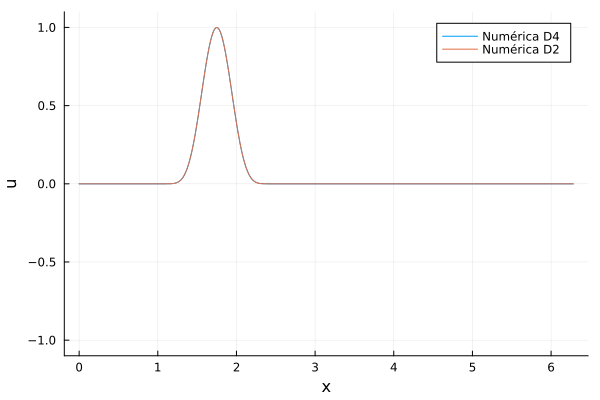

In [71]:
anim = @animate for t in solmatricialD4.t[1:4:end]
    plot(x, solmatricialD4(t), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Numérica D4")
    plot!(x, solmatricial(t), yaxis = ("u", (-1.1,1.1)), xlabel = "x", label = "Numérica D2")
    #plot(sol2(T*0.005*i)[:,1])
end

gif(anim, "wave_anim_matricial_D4.gif", fps = 30)

**4)** Considere ahora la ecuación de onda, $\phi_{tt} = c^2 \phi_{xx}$. Descompóngala en una ecuación ordinaria, un modo propagando hacia la izquierda y otro hacia la derecha. **Ayuda:** Vea que ecuación satisface la combinación $V_+ := \phi_t - c\phi_x$. Use esta descomposición para dar condiciones de contorno de forma que el problema quede completamente determinado (pero no sobredeterminado). Considere los siguientes casos: 
1. Condiciones de contorno nulas, nada entra, dato inicial no nulo.
2. Condiciones de contorno reflejantes, lo que llega por un modo entra por el otro. Para dar esta condición elija la combinación de modos en el borde de forma tal que $\phi$ se mantenga constante en el tiempo. 

## Ecuación de Onda


\begin{equation}
\phi_{tt} = c^2 \phi_{xx}
\end{equation}

**Descomposición en ODE**
Definiremos dos nuevas variables, $u := c^2\phi_x$ y $v := \phi_t$. Este sistema entonces se convierte en

$$
\begin{align}
\phi_t & =  v \\
v_t & =  u_x \\
u_t & = c^2 v_x,
\end{align}
$$

donde hemos usado que $u_t := \phi_{xt} = \phi_{tx} := v_x$, y $v_t :=\phi_{tt} = c^2\phi_{xx} = u_x$.  

Dado que la ecuación para $\phi$ puede ser integrada una vez conocidos $(u,v)$, y que $\phi$ no es necesario para resolver el resto del sistema, lo ignoraremos por el momento.

### Diagonalización del sistema

Si definimos las variables $u^{+} = v-\frac{1}{c}u$ y $u^{-} = v+\frac{1}{c}u$ podemos obtener un sistema diagonalizado, 

$$
\begin{align}
u^+_t & = & -c \cdot u^+_x \\
u^-_t & = & c \cdot u^-_x,
\end{align}
$$
donde la solución son dos ondas independientes, $u^{+}$ hacia la izquierda y $u^{-}$ hacia la derecha:


**5)** **Para los intrépidos:** Considere dos regiones contiguas, $L_L$ y $L_R$ en ellas evolucionan una ecuación de onda pero con distintas velocidades $(c_L, c_R)$ (imagine que las regiones son cuerdas y están construidas con de distintos medios o densidades). Trate la interfase entre los medios como un lugar donde uno da condiciones de contorno de acuerdo a lo que proviene de la otra región. Elija estas condiciones de manera que $\phi_t$ y $\phi_x$ sean continuas a través de la interfase. Implemente el código reflejando la situación descripta. Implemente condiciones de contorno en la parte izquierda de $L_L$ de forma que ingrese una onda sinusoidal. Implemente condiciones de contorno en la parte derecha de $L_R$ de forma que la onda saliente rebote y se convierta en entrante. 

Un ejemplo a lo que debería llegar:
![Cuerdas](ropes_anim_fps20.gif "ejemplo")